In [1]:
%pip install albumentations==0.4.6
%pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# ref: https://www.aicrowd.com/showcase/tutorial-with-pytorch-torchvision-and-pytorch-lightning

In [3]:
# Common imports
import math
import sys
import time
from tqdm.notebook import tqdm
import numpy as np
from pathlib import Path
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt

# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as transforms
from torchvision.ops.boxes import box_iou
from torchvision.models.detection._utils import Matcher
from torchvision.ops import nms, box_convert
import torch.nn.functional as F

# Albumentations is used for the Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Pytorch import
from pytorch_lightning.core import LightningModule
from pytorch_lightning import Trainer, seed_everything

from datasets import load_dataset

/Users/rabahabdulkhalek/Documents/giskard_repos/giskard-vision/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("mps")

In [5]:
ds = load_dataset("Etienne-David/GlobalWheatHeadDataset2021", split="test")

In [6]:
def format_bbox(bboxes):
    # format: [x,y,w,h] -> [x_min,y_min, x_max,y_max]
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]

    return bboxes

In [7]:
class WheatDataset(Dataset):
    """A dataset example for GWC 2021 competition."""

    def __init__(self, split="test", transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional data augmentation to be applied
                on a sample.
        """

        self.hf_dataset = load_dataset("Etienne-David/GlobalWheatHeadDataset2021", split=split)

        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        bboxes = self.hf_dataset[idx]["objects"]["boxes"]
        bboxes = np.array(bboxes) if bboxes else np.zeros((0, 4))
        bboxes = format_bbox(bboxes)
        domain = self.hf_dataset[idx]["domain"]

        image = np.array(self.hf_dataset[idx]["image"])

        if self.transform:
            transformed = self.transform(
                image=image, bboxes=bboxes, class_labels=["wheat_head"] * len(bboxes)
            )  # Albumentations can transform images and boxes
            image = transformed["image"]
            bboxes = transformed["bboxes"]

        else:
            image = torch.tensor(image).float()
            bboxes = torch.tensor(bboxes).float()

        if len(bboxes) > 0:
            bboxes = torch.stack([torch.tensor(item).float() for item in bboxes])
        else:
            bboxes = torch.zeros((0, 4))
        return image, bboxes, domain

In [8]:
transform = A.Compose(
    [
        A.LongestMaxSize(1024, p=1),
        A.PadIfNeeded(min_height=1024, min_width=1024, p=1, border_mode=1, value=0),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"], min_area=20),
)

In [9]:
dataset = WheatDataset("train", transform=transform)

In [10]:
def collate_fn(batch):
    """
    Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

    :param batch: an iterable of N sets from __getitem__()
    :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
    """

    images = list()
    targets = list()
    metadatas = list()

    for i, t, m in batch:
        images.append(i)
        targets.append(t)
        metadatas.append(m)
    images = torch.stack(images, dim=0)

    return images, targets, metadatas


train_size = int(len(dataset) * 0.9)
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)  # We sample 10% of the images as a validation dataset
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=False, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [11]:
batch = next(iter(train_dataloader))

In [12]:
seed_everything(25081992)


class FasterRCNN(LightningModule):
    def __init__(self, n_classes):
        super().__init__()
        self.detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.detector.roi_heads.box_predictor.cls_score.in_features
        self.detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)
        self.lr = 1e-4

    def forward(self, imgs, targets=None):
        # Torchvision FasterRCNN returns the loss during training
        # and the boxes during eval
        self.detector.eval()
        return self.detector(imgs)

Seed set to 25081992


In [13]:
detector = FasterRCNN(2)

/Users/rabahabdulkhalek/Documents/giskard_repos/giskard-vision/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rabahabdulkhalek/Documents/giskard_repos/giskard-vision/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
class WheatDatasetPredict(Dataset):
    """A dataset example for GWC 2021 competition."""

    def __init__(self, split="test"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.hf_dataset = load_dataset("Etienne-David/GlobalWheatHeadDataset2021", split=split)

        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        bboxes = self.hf_dataset[idx]["objects"]["boxes"]
        bboxes = np.array(bboxes) if bboxes else np.zeros((0, 4))
        bboxes = format_bbox(bboxes)
        domain = self.hf_dataset[idx]["domain"]

        image = np.array(self.hf_dataset[idx]["image"])

        if self.transform:
            transformed = self.transform(
                image=image, bboxes=bboxes, class_labels=["wheat_head"] * len(bboxes)
            )  # Albumentations can transform images and boxes
            transformed_image = transformed["image"]
        else:
            transformed_image = torch.tensor(image).float()

        return transformed_image, image, bboxes, domain

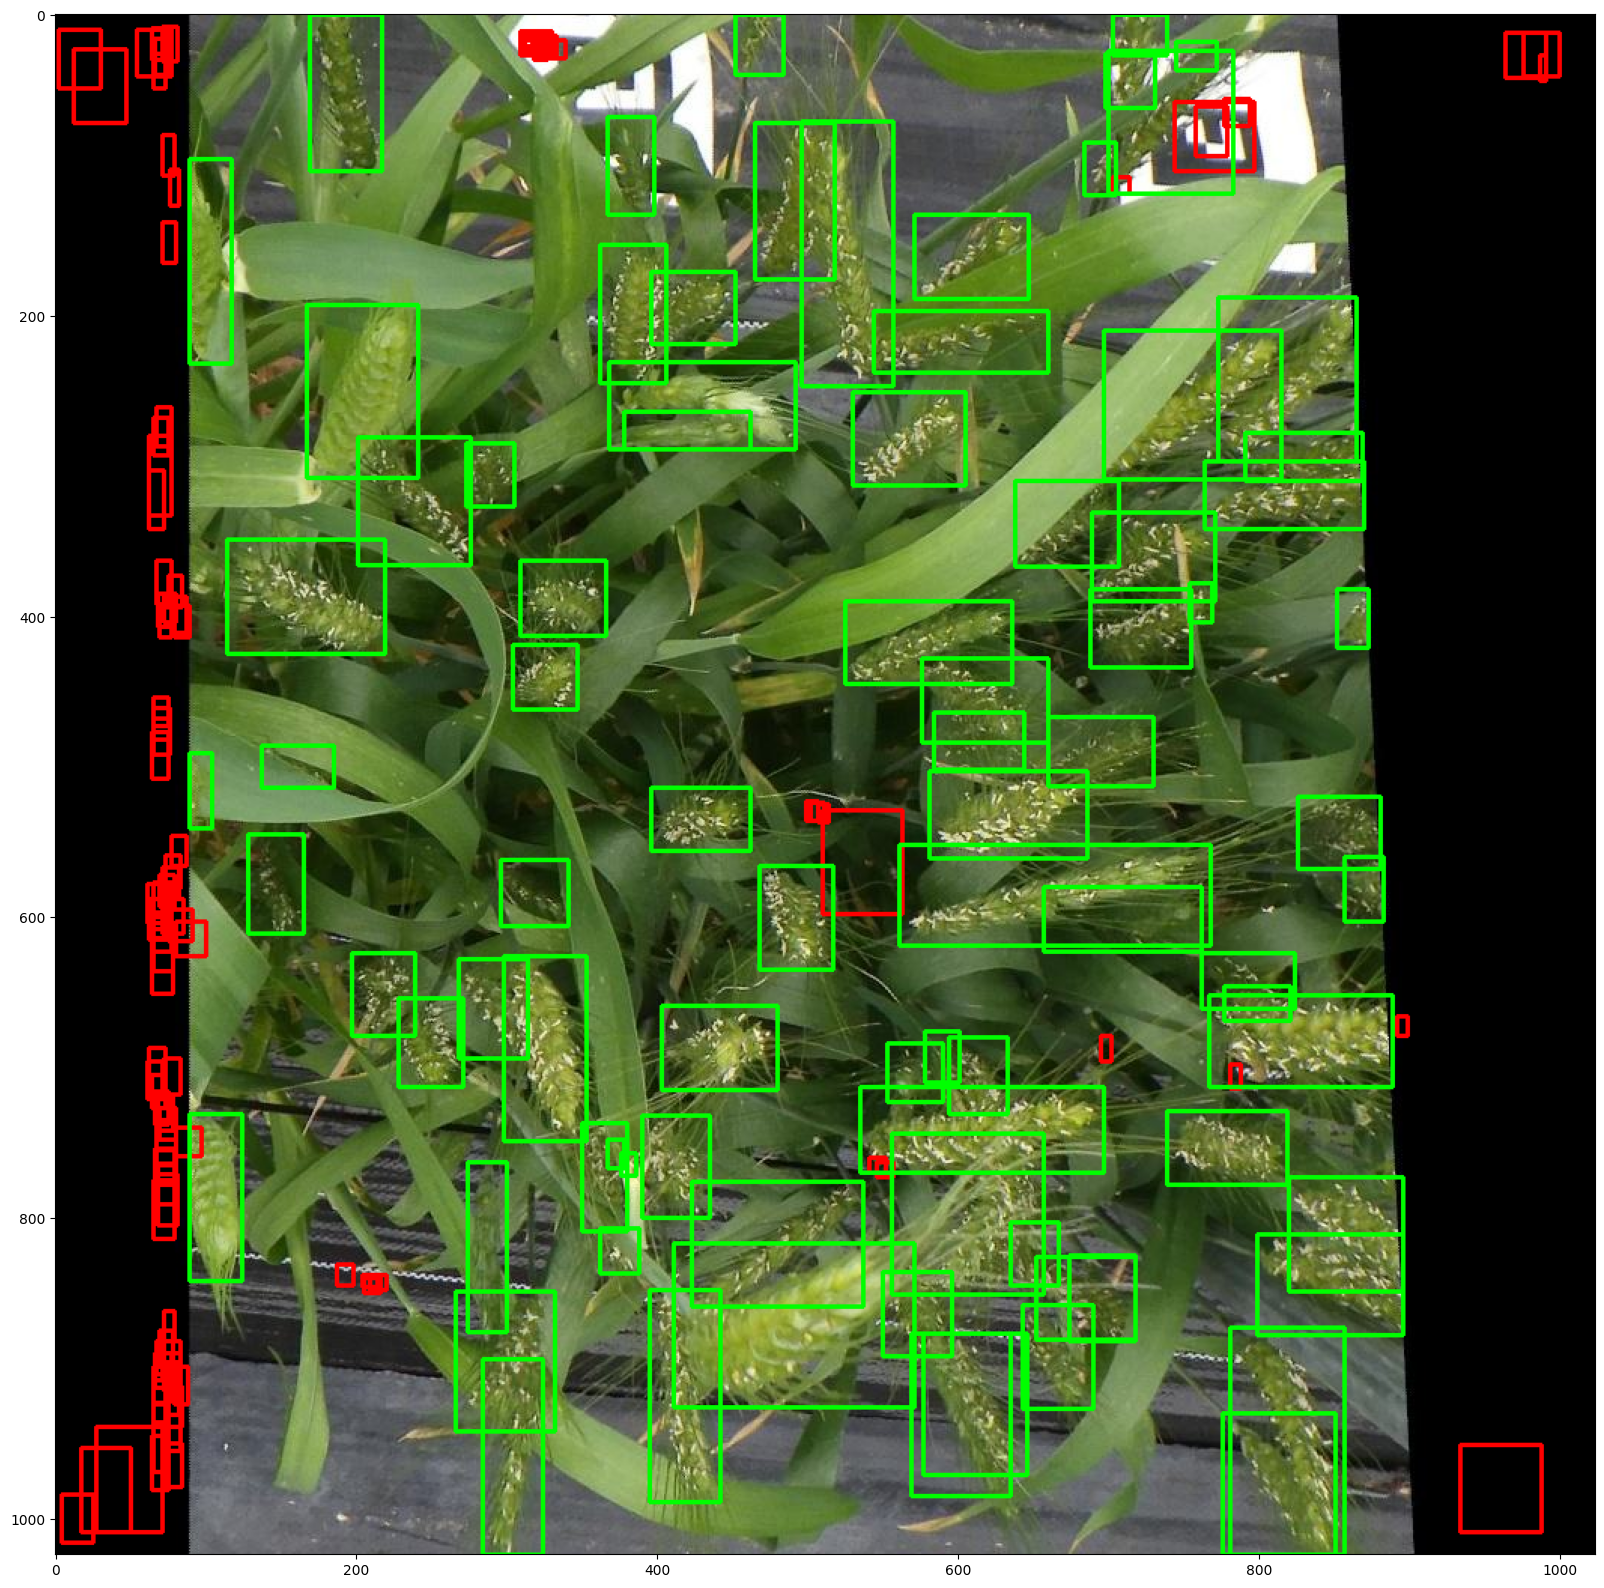

In [22]:
detector.freeze()

test_dataset = WheatDatasetPredict()

hlines = []

n_img = 1

for i in range(n_img):
    vlines = []
    for j in range(n_img):
        idx = 2  # random.randint(0, len(test_dataset))

        norm_img, img, bboxes_ground_truth, domain = test_dataset[
            idx
        ]  # norm_image is used for prediction and img for visualisation

        predictions = detector(norm_img.unsqueeze(dim=0))

        pboxes = predictions[0]["boxes"]
        scores = predictions[0]["scores"]
        pboxes = pboxes[scores > 0.5]

        for x, y, xx, yy in pboxes:
            cv2.rectangle(img, (int(x.item()), int(y.item())), (int(xx.item()), int(yy.item())), (255, 0, 0), 2)

        for x, y, xx, yy in bboxes_ground_truth:
            cv2.rectangle(img, (int(x.item()), int(y.item())), (int(xx.item()), int(yy.item())), (0, 255, 0), 2)

        vlines.append(img)
    hlines.append(cv2.vconcat(vlines))

final_img = cv2.hconcat(hlines)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(final_img)